<h1>Segmentation of ISIC data using improved UNET </h1>

<p>This notebook is inspired from the UNET architecture given in the research paper given by F. Isensee, P. Kickingereder, W. Wick, M. Bendszus, and K. H. Maier-Hein</p>

## Import the libraries

In [1]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, concatenate, Conv2DTranspose, Dropout
#from dataset import *

In [2]:
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Importing the images data

In [3]:
transformed_X = 256
transformed_Y = 256
def load_images(path):
    image_list = []
    for fi in os.listdir(path):
    #print(fi)
        if fi.endswith(".csv") or "superpixels" in fi:
            continue
        img = cv2.imread(os.path.join(path, fi),cv2.IMREAD_COLOR)
        img = cv2.resize(img,(transformed_Y,transformed_X))
        img = img / 255.0
        img = img.astype(np.float32)
        image_list.append(img)
    image_list = np.array(image_list)
    return image_list

## Loading the masks images

In [4]:
def load_masks(path):
    masks_list = []
    for fi in os.listdir(path):
    #print(fi)
        if fi.endswith(".csv") or "superpixels" in fi:
            continue
        mask = cv2.imread(os.path.join(path, fi),cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask,(transformed_Y,transformed_X),interpolation = cv2.INTER_NEAREST)
        mask = mask / 255.0
        mask = mask.astype(np.float32)
        mask = np.expand_dims(mask, axis=-1) 
        masks_list.append(mask)
    masks_list = np.array(masks_list)
    return masks_list

## loading training data

In [5]:
X_train = load_images("ISIC-2017_Training_Data/")
masks_train_images = load_masks("ISIC-2017_Training_Part1_GroundTruth/")

In [6]:
X_train.shape

(2000, 256, 256, 3)

## Loading validation data

In [7]:
x_validate = load_images("ISIC-2017_Validation_Data/")
masks_valid_images = load_masks("ISIC-2017_Validation_Part1_GroundTruth")

In [8]:
#x_validate = np.expand_dims(x_validate, axis=3)
#masks_valid_images = np.expand_dims(masks_valid_images, axis=3)

## Loading test data

In [9]:
x_test = load_images("ISIC-2017_Test_v2_Data/")
masks_test_images = load_masks("ISIC-2017_Test_v2_Part1_GroundTruth")

In [10]:
X_train.shape

(2000, 256, 256, 3)

## Model implementation of Improved UNET

<p> It consists of two parts encoding and decoding. It starts with downsampling of data and then it starts upsampling to original structure </p>

In [11]:
def unet_model():
    inputs = Input((256, 256, 3))
    x = inputs 

    conv1 = Conv2D(16,(3,3), padding="same", activation="relu", kernel_initializer="he_normal")(x)
    conv1 = Dropout(0.1)(conv1)
    conv1 = Conv2D(16,(3,3), padding="same", activation="relu", kernel_initializer="he_normal")(conv1)
    pool1 = MaxPooling2D((2,2))(conv1)

    conv2 = Conv2D(32,(3,3), padding="same", activation="relu", kernel_initializer="he_normal")(pool1)
    conv2 = Dropout(0.1)(conv2)
    conv2 = Conv2D(32,(3,3), padding="same", activation="relu", kernel_initializer="he_normal")(conv2)
    pool2 = MaxPooling2D((2,2))(conv2)

    conv3 = Conv2D(64,(3,3), padding="same", activation="relu", kernel_initializer="he_normal")(pool2)
    conv3 = Dropout(0.1)(conv3)
    conv3 = Conv2D(64,(3,3), padding="same", activation="relu", kernel_initializer="he_normal")(conv3)
    pool3 = MaxPooling2D((2,2))(conv3)

    conv4 = Conv2D(128,(3,3), padding="same", activation="relu", kernel_initializer="he_normal")(pool3)
    conv4 = Dropout(0.1)(conv4)
    conv4 = Conv2D(128,(3,3), padding="same", activation="relu", kernel_initializer="he_normal")(conv4)
    pool4 = MaxPooling2D((2,2))(conv4)

    conv5 = Conv2D(256,(3,3), padding="same", activation="relu", kernel_initializer="he_normal")(pool4)
    conv5 = Dropout(0.1)(conv5)
    conv5 = Conv2D(256,(3,3), padding="same", activation="relu", kernel_initializer="he_normal")(conv5)
    pool5 = MaxPooling2D((2,2))(conv5)

    upconv6 = Conv2DTranspose(128,(2,2),strides = (2,2),padding="same")(conv5)
    upconv6 = concatenate([upconv6, conv4])
    conv6 = Conv2D(128,(3,3), padding="same", activation="relu", kernel_initializer="he_normal")(upconv6)
    conv6 = Dropout(0.1)(conv6)
    conv6 = Conv2D(128,(3,3), padding="same", activation="relu", kernel_initializer="he_normal")(conv6)

    upconv7 = Conv2DTranspose(64,(2,2),strides = (2,2),padding="same")(conv6)
    upconv7 = concatenate([upconv7, conv3])
    conv7 = Conv2D(64,(3,3), padding="same", activation="relu", kernel_initializer="he_normal")(upconv7)
    conv7 = Dropout(0.1)(conv7)
    conv7 = Conv2D(64,(3,3), padding="same", activation="relu", kernel_initializer="he_normal")(conv7)

    upconv8 = Conv2DTranspose(32,(2,2),strides = (2,2),padding="same")(conv7)
    upconv8 = concatenate([upconv8, conv2])
    conv8 = Conv2D(32,(3,3), padding="same", activation="relu", kernel_initializer="he_normal")(upconv8)
    conv8 = Dropout(0.1)(conv8)
    conv8 = Conv2D(32,(3,3), padding="same", activation="relu", kernel_initializer="he_normal")(conv8)

    upconv9 = Conv2DTranspose(16,(2,2),strides = (2,2),padding="same")(conv8)
    upconv9 = concatenate([upconv9, conv1],axis=3)
    conv9 = Conv2D(16,(3,3), padding="same", activation="relu", kernel_initializer="he_normal")(upconv9)
    conv9 = Dropout(0.1)(conv9)
    conv9 = Conv2D(16,(3,3), padding="same", activation="relu", kernel_initializer="he_normal")(conv9)

    outputs = Conv2D(1,(1,1),activation="sigmoid")(conv9)

    cnn_model = Model(inputs = [inputs], outputs=[outputs])
    return cnn_model

In [12]:
model = unet_model()

## Dice similarity coefficient

In [13]:
import tensorflow as tf
def dice_coef(y_true, y_pred, smooth = 1e-15):
    y_true = tf.convert_to_tensor(y_true, dtype='float32')
    y_pred = tf.convert_to_tensor(y_pred, dtype='float32')
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

In [14]:
def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

## Compile the model and observe the summary

In [15]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics = [dice_coef])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

## Fit the model on training images and evaluate the result on validation data. Accuracy can be increased by increasing epochs

In [26]:
model.fit(X_train, masks_train_images, batch_size=8, epochs=10,
               validation_data=(x_validate, masks_valid_images))

Epoch 1/10
250/250 [==============================] - 300s 1s/step - loss: 0.1383 - dice_coef: 0.7893 - val_loss: 0.1854 - val_dice_coef: 0.6293
Epoch 2/10
250/250 [==============================] - 287s 1s/step - loss: 0.1367 - dice_coef: 0.7900 - val_loss: 0.2006 - val_dice_coef: 0.6436
Epoch 3/10
250/250 [==============================] - 315s 1s/step - loss: 0.1347 - dice_coef: 0.7920 - val_loss: 0.1967 - val_dice_coef: 0.6968
Epoch 4/10
250/250 [==============================] - 300s 1s/step - loss: 0.1274 - dice_coef: 0.8030 - val_loss: 0.2090 - val_dice_coef: 0.6579
Epoch 5/10
250/250 [==============================] - 312s 1s/step - loss: 0.1275 - dice_coef: 0.8024 - val_loss: 0.2067 - val_dice_coef: 0.6419
Epoch 6/10
250/250 [==============================] - 298s 1s/step - loss: 0.1214 - dice_coef: 0.8099 - val_loss: 0.1978 - val_dice_coef: 0.6552
Epoch 7/10
250/250 [==============================] - 300s 1s/step - loss: 0.1189 - dice_coef: 0.8147 - val_loss: 0.2120 - val_dic

## Save the model

In [17]:
model.save("improved_UNET.h5")

## Plot the result for loss and validation loss

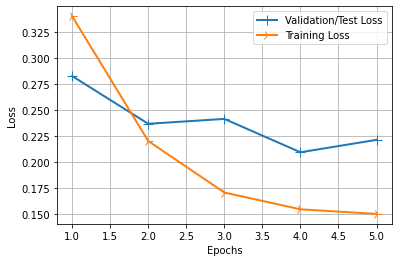

In [18]:

# Plotting our loss charts
import matplotlib.pyplot as plt

# Use the History object we created to get our saved performance results
history_dict = model.history.history

# Extract the loss and validation losses
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

# Get the number of epochs and create an array up to that number using range()
epochs = range(1, len(loss_values) + 1)

# Plot line charts for both Validation and Training Loss
line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

## Plot the result for dice coefficient and validation dice coefficient

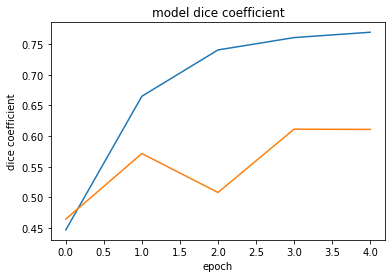

In [19]:
# Plotting the graph for dice coefficient
plt.plot(model.history.history['dice_coef'])
plt.plot(model.history.history['val_dice_coef'])
plt.title('model dice coefficient')
plt.ylabel('dice coefficient')
plt.xlabel('epoch')
plt.show()

## Loading the test data and masks

In [20]:
x_test = load_images("ISIC-2017_Test_v2_Data/")
masks_test_images = load_masks("ISIC-2017_Test_v2_Part1_GroundTruth")

In [21]:
x_test.shape

(600, 256, 256, 3)

## Evaluate the result

In [22]:
model.evaluate(x_test, masks_test_images)

19/19 [==============================] - 12s 616ms/step - loss: 0.2915 - dice_coef: 0.6298


[0.2915244698524475, 0.6297784447669983]

## prediction images

In [23]:
pred_image = np.round(model.predict(x_test,batch_size=8))

75/75 [==============================] - 13s 171ms/step


In [25]:
# dice coefficient
dice = dice_coef(masks_test_images, pred_image, smooth = 1e-15)
print(dice)

tf.Tensor(0.70143276, shape=(), dtype=float32)


In [ ]:
#masks_test_images = masks_test_images.reshape(masks_test_images.shape[0], img_rows, img_cols, 1)

## perform visualization to see actual vs predicted images

In [ ]:
def imshow(title, image = None, size = 20):
    if image.any():
        w, h = image.shape[0], image.shape[1]
        aspect_ratio = w/h
        plt.figure(figsize=(size * aspect_ratio,size))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.show()
    else:
        print("Image not found")


In [ ]:
for i in range(0,6):
    random_num = np.random.randint(0, len(masks_test_images))
    img = masks_test_images[random_num]
    img1 = pred_image[random_num]
    img_concate_Hori=np.concatenate((img,img1),axis=1)
    imshow("Ground Truth & prediction",img_concate_Hori , size = 2)
